In [366]:
import sys
import os

from datetime import datetime

sys.path.insert(0, './src/')

from FRAPanalyzer.lifproc import LIFContainer
from FRAPanalyzer.lifproc import start_bioformats
from FRAPanalyzer.lifproc import stop_bioformats
from pprint import pprint

from collections import OrderedDict
import numpy as np

from IPython.display import HTML
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import patches
from ipywidgets import widgets

from scipy import ndimage

In [2]:
%matplotlib notebook

In [3]:
start_bioformats()

BioContainer started


In [14]:
class Preprocessing:
    def __init__(self, verbose=False):
        self.verbose = verbose
    
    def get_lsms(self):
        from glob import glob
        mask = './test_data/06.04.2014*.lsm'    
        lsms = glob(mask)
        if self.verbose:
            print(lsms)
            
        return lsms
    
    def prepare_img(self, lsm):
        if self.verbose:
            print lsm
        self.lif = LIFContainer(lsm)

        series_id = self.lif.lif_img_data.keys()[0]
        self.current_series_id = self.lif.lif_series_order.index(series_id)
        self.img = self.lif.get_full_array(series_id, progressbar=True)
        self.img = self.img[:,:,0,:]
    
        if self.verbose:
            print(self.lif.lif_img_data)
            print(self.lif.lif_img_data[series_id])
            print(self.img.shape)
            
    def prepare_rois(self):
        self.rois_struc = self.lif.get_rois_from_oemxml()

In [101]:
def plot_image(imgs, save=False, cmap=None):
    def init():
        ax.set_data(imgs[:,:,0])
        return ax,

    def animate(i):
        ax.set_data(imgs[:,:,i])
        return ax,
    
    fig = plt.figure()
    ax = plt.imshow(imgs[:,:,0], cmap=cmap)
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=imgs.shape[-1])#, interval=20, blit=True)
    
    if not save:
        return anim
    else:
        anim.save(
            os.path.join(
                'static','{}.avi'.format(
                    datetime.now().strftime('%Y%m%d%H%M%S')
                )
            ),
            fps=1,
            extra_args=['-vcodec', 'libx264']
        )

        return HTML(anim.to_html5_video())
    

In [337]:
preproc = Preprocessing(verbose=True)
lsms = preproc.get_lsms()
preproc.prepare_img(lsms[2])
preproc.prepare_rois()

['./test_data/06.04.2014 3T3 HP-Btk FRAP.lsm', './test_data/06.04.2014 3T3 HP-Btk FRAP1.lsm', './test_data/06.04.2014 3T3 HP-Btk FRAP2.lsm']
./test_data/06.04.2014 3T3 HP-Btk FRAP2.lsm


100%|██████████| 156/156 [00:08<00:00, 20.51it/s]

OrderedDict([('06.04.2014 3T3 HP-Btk FRAP2', {'C': 1, 'T': 156, 'Y': 512, 'X': 512, 'Z': 1, 'ID': 'Image:0'})])
{'C': 1, 'T': 156, 'Y': 512, 'X': 512, 'Z': 1, 'ID': 'Image:0'}
(512, 512, 156)


<IPython.core.display.Javascript object>


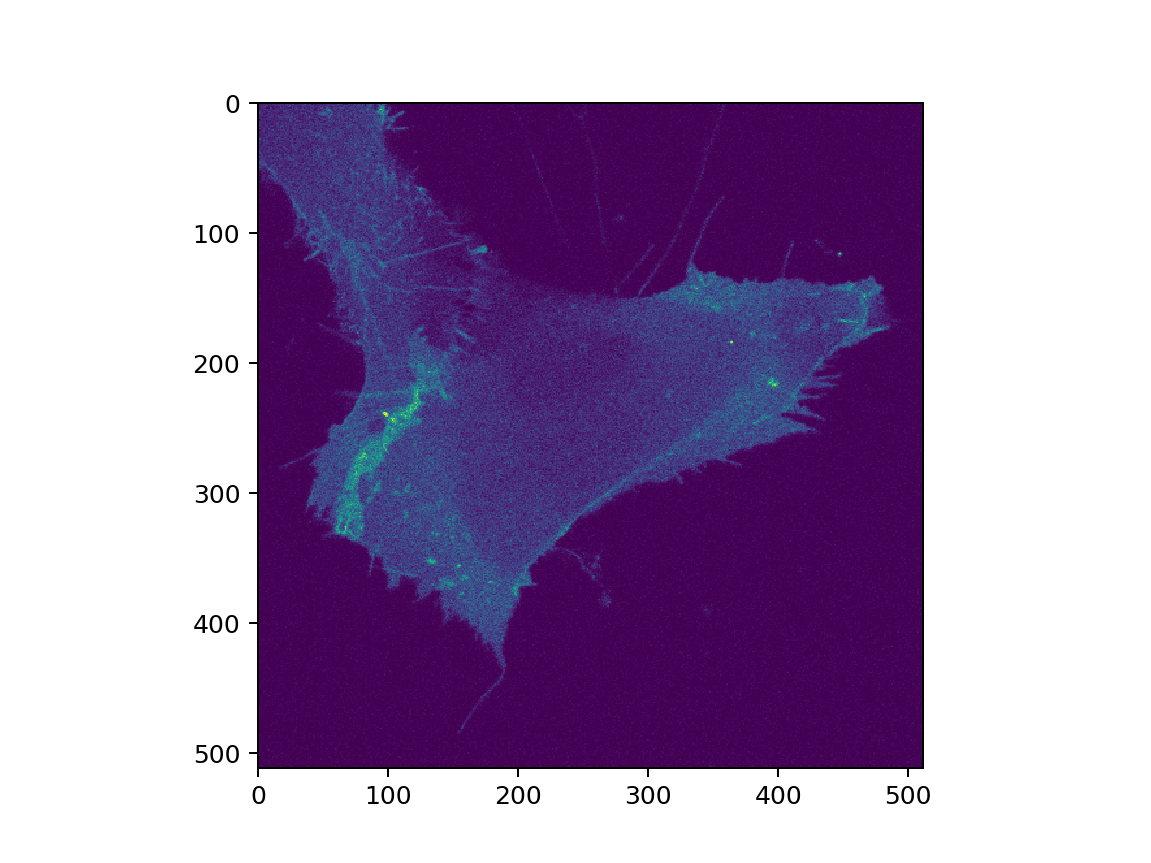

In [338]:
# plot process
plot_image(preproc.img)

In [377]:
class Processing:
    def __init__(self): pass
    
    @staticmethod
    def circle_mask(shape, centre, radius):
        """
        Return a circle mask
        """
        x, y = np.ogrid[:shape[0], :shape[1]]
        cx, cy = centre
        r2 = (x - cx) * (x - cx) + (y - cy) * (y - cy)
        return r2 <= radius * radius
    
    @staticmethod
    def crop_matrix(A, padding=0):
        size = A.shape
        B = np.argwhere(A)
        (ystart, xstart), (ystop, xstop) = B.min(0), B.max(0) + 1
        ystart = max(0, ystart - padding)
        xstart = max(0, xstart - padding)
        ystop = min(ystop + padding, size[0])
        xstop = min(xstop + padding, size[1])
        return ystart, ystop, xstart, xstop
    
    def process_filter(self, imgs, func_h, func_v):
        _frames = (np.zeros_like(imgs), np.zeros_like(imgs))

        for i in tqdm_notebook(range(imgs.shape[-1]), total=imgs.shape[-1]):
            _frames[0][:,:,i] = func_h(imgs[:,:,i])
            _frames[1][:,:,i] = func_v(imgs[:,:,i])
        return _frames
    
    
    def process_join(self, frames, func, **kwargs):
        return map(lambda ar: func(ar, **kwargs), frames)

In [329]:
def get_show_cropped():
    fig = plt.figure(figsize=(13,5))
    
    roi_masks = [0,0,0]
    shp = img[:,:,3].shape
    sumofrois = np.zeros(shp)

    for _id, roi in enumerate(['ROI:0', 'ROI:1', 'ROI:2']):
        RadiusX, RadiusY, X, Y = map(preproc.rois_struc[roi][0].get, ('RadiusX', 'RadiusY', 'X', 'Y'))
    #     sumofrois += circle_mask(shp, (Y, X), RadiusX)
        msk = Processing.circle_mask(shp, (Y, X), RadiusX)
        ystart, ystop, xstart, xstop = roi_masks[_id] = Processing.crop_matrix(msk, padding=20)
        ax = plt.subplot(1, 3, _id + 1)
        ax.imshow(img[ystart:ystop, xstart:xstop, 3])
        ax.set_title(roi)
    
    #     ellipse = patches.Ellipse(xy=(X, Y), width=2*RadiusX, height=2*RadiusY, linewidth=2.0, fill=False)
    #     fig.gca().add_artist(ellipse)

    # plt.imshow(sumofrois)
    ax.set_aspect('equal')
    return roi_masks

<IPython.core.display.Javascript object>


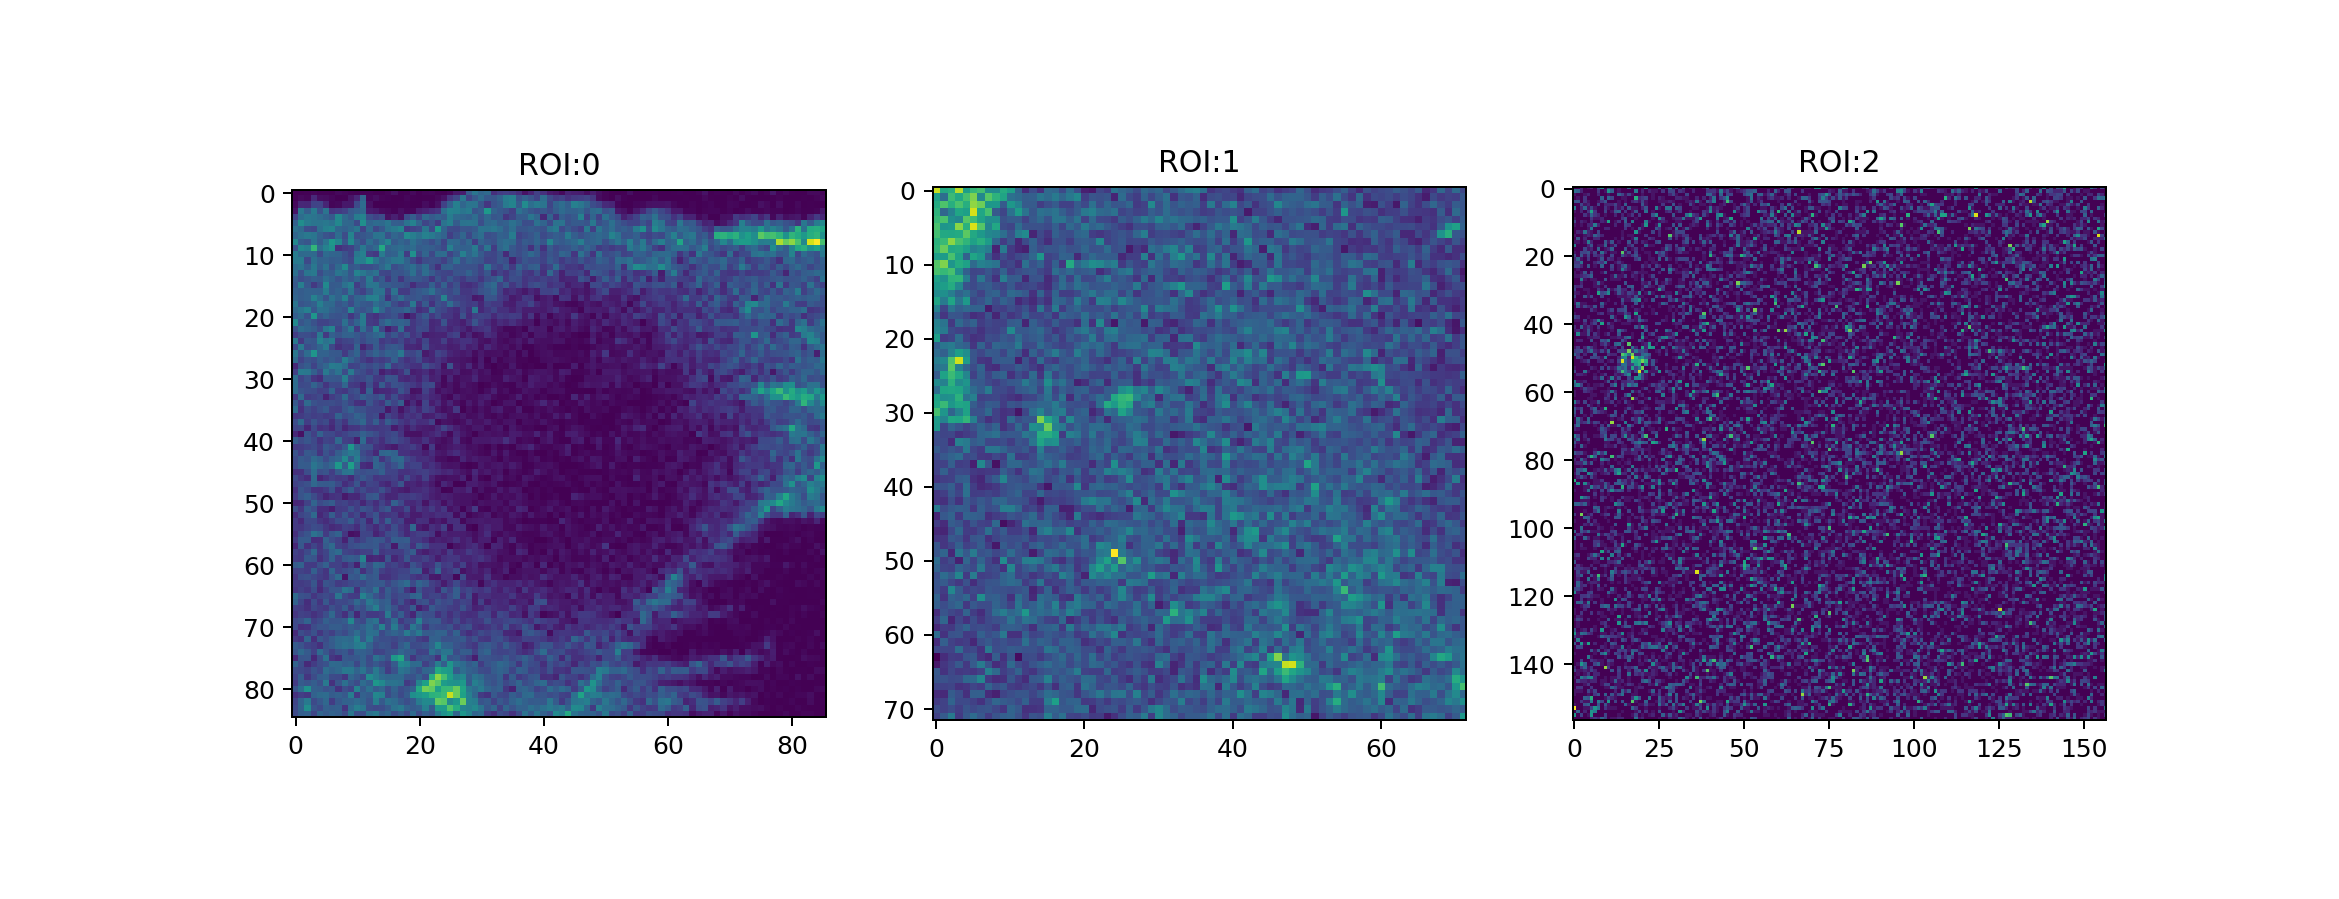

In [339]:
# show cropped regions
roi_masks = get_show_cropped()

<IPython.core.display.Javascript object>


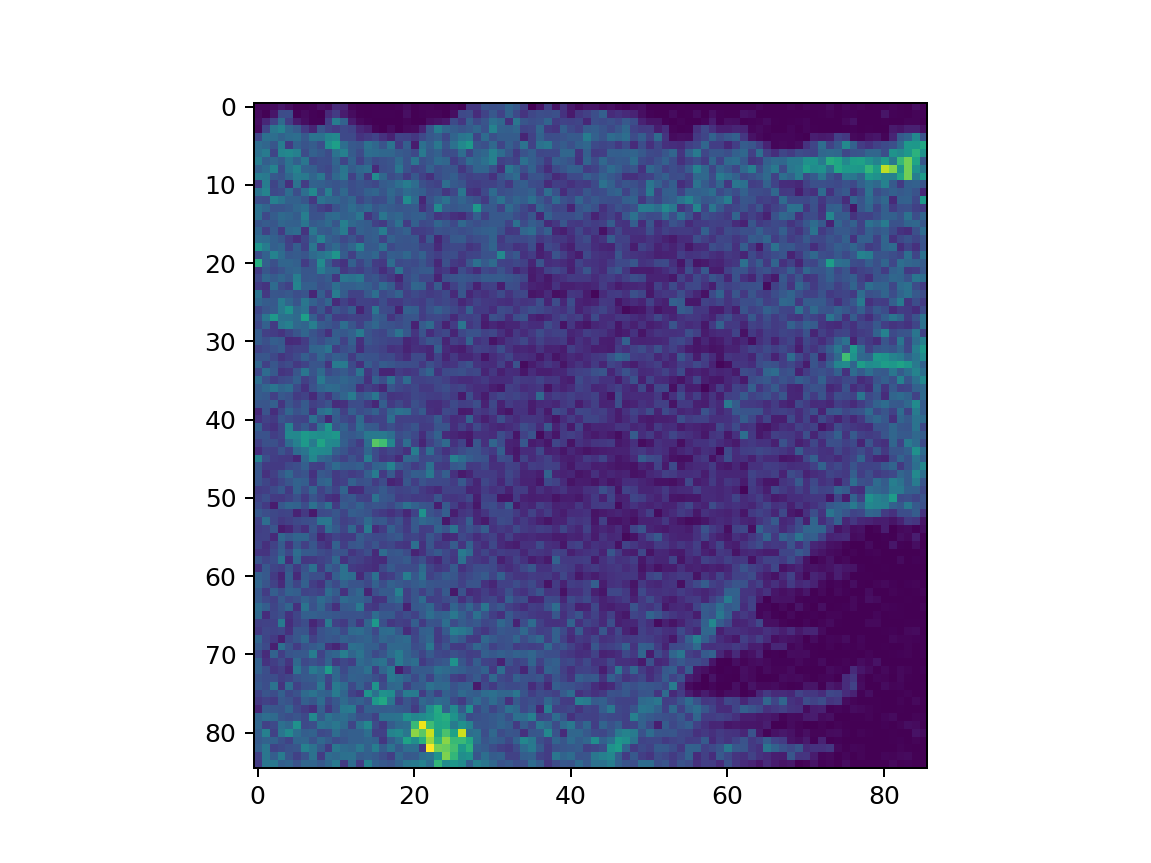

In [381]:
# cropped area process (lot of pictures)
yst, ystp, xst, xstp = roi_masks[0]
roi0_imgs = img[yst:ystp,xst:xstp,:]
plot_image(roi0_imgs)

In [129]:
def plot_filtered(roi_img_prepared, roi_imgs, sidestep, save=False):
    shape = roi_imgs.shape
    Ymesh, Xmesh = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))

    fig = plt.figure()
    tstep = 0
    _s = sidestep
    V, U = roi_img_prepared

    Q = plt.quiver(Xmesh[::_s, ::_s], Ymesh[::_s, ::_s],
                   U[::_s, ::_s, 0], V[::_s, ::_s, 0],
                   color='r', units='x',
                   linewidths=(0.5,), edgecolors=('r'), headaxislength=5)
    
    # qk = plt.quiverkey(Q, 0.5, 0.03, 1, r'$1 \frac{m}{s}$', fontproperties={'weight': 'bold'})

    ax = plt.imshow(roi_imgs[:,:,_s], cmap=plt.cm.gray)

    def init():
        Q.set_UVC(U[::_s, ::_s, 0], V[::_s, ::_s, 0])
        ax.set_data(roi_imgs[:,:,0])
        return Q,

    def animate(i):
        Q.set_UVC(U[::_s, ::_s, i], V[::_s, ::_s, i])
        ax.set_data(roi_imgs[:,:,i])
        return Q,

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=60) #, interval=20, blit=True)
    if not save:    
        return anim
    
    else:
        anim.save('quiver_with_roi.avi', fps=1, extra_args=['-vcodec', 'libx264'])
        return HTML(anim.to_html5_video())

In [80]:
def win_average(arr, n=3):
    """
    :param n: size of the window
    :param arr: result of filter (in particular case - sobel filter)
    """
    length = arr.shape[-1]
    
    # reduce shape because of first window
    # see [0][1][2][3] --> ([0] + [1] + [2]), ([1] + [2] +[3])
    # just two rows instead of 4 
    # 4 - (3 - 1) = 2
    result = np.zeros(arr.shape[:2] + (length - n + 1,))
    # just the average inside the window
    for i in range(length - n + 1):
        result[:, :, i] = arr[:, :, i:i + n].sum(axis=2) / n
    return result

In [317]:
def win_gaus(arr, n=3, **kwargs):
    """
    :param n: size of the window
    :param arr: result of filter (in particular case - sobel filter)
    """
    length = arr.shape[-1]
    result = np.zeros(arr.shape[:2] + (length - n + 1,))

    # lets make gauss for all images and i is central
    mask = np.zeros(length)
    center = np.ceil(float(length) / 2).astype(int)
    mask[center] = 1
    time_filter = gaussian_filter1d(mask, **kwargs)[center - np.floor(float(n) / 2).astype(int):
                                                    center + np.ceil(float(n) / 2).astype(int)]
    for i in range(length - n + 1):
        for j, e in enumerate(time_filter):
            result[:, :, i] += e * arr[:, :, i + j]    
    return result
    

In [333]:
from skimage.filters import prewitt_v, prewitt_h
from skimage.filters import roberts_pos_diag, roberts_neg_diag
from skimage.filters import sobel_h, sobel_v

In [334]:
proc = Processing()

In [367]:
# if need gauss smoothing


<IPython.core.display.Javascript object>


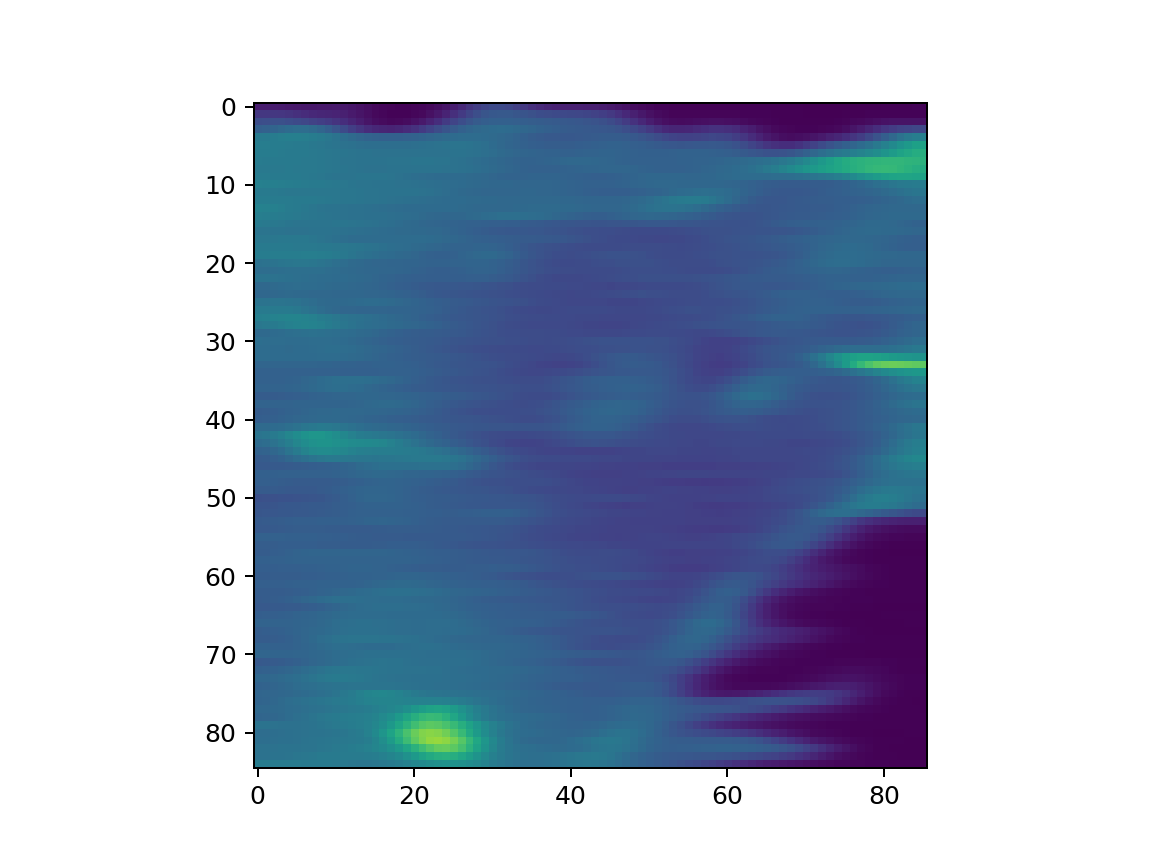

In [368]:
plot_image(np.array(tests))

<IPython.core.display.Javascript object>


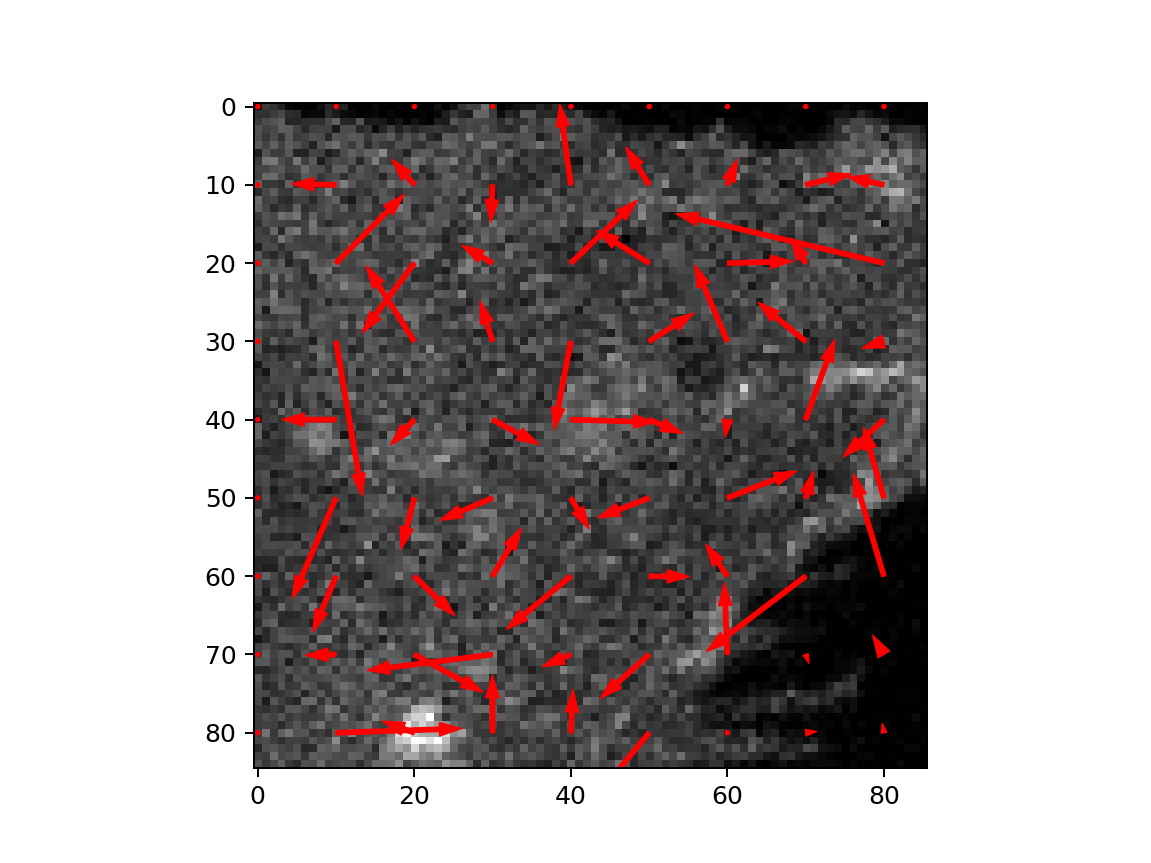

In [384]:
def make_experiment(filter_h, filter_v, roi_imgs, smooth_func=None, win_func=win_gaus, **kwargs):
    
    smooth_sigma = kwargs.pop('smooth_sigma', 3)
    if not smooth_func:
        _frames = proc.process_filter(roi_imgs, filter_h, filter_v)
    else:
        
        roi_imgs_smooth = map(lambda img: smooth_func(img, sigma=smooth_sigma), roi_imgs)
        _frames = proc.process_filter(np.array(roi_imgs_smooth), filter_h, filter_v)
        
    n = kwargs.get('n', 5)
    av_roi_img = proc.process_join(_frames, win_gaus, **kwargs)
    
    return plot_filtered(av_roi_img, np.array(roi0_imgs), sidestep=n)
    
make_experiment(
    filter_h=sobel_h,
    filter_v=sobel_v,
    win_func=win_gaus,
    smooth_func=ndimage.gaussian_filter,
    roi_imgs=roi0_imgs,
    n=10,
    smooth_sigma=3,
    sigma=0.4,
    truncate=3
)
    

<IPython.core.display.Javascript object>


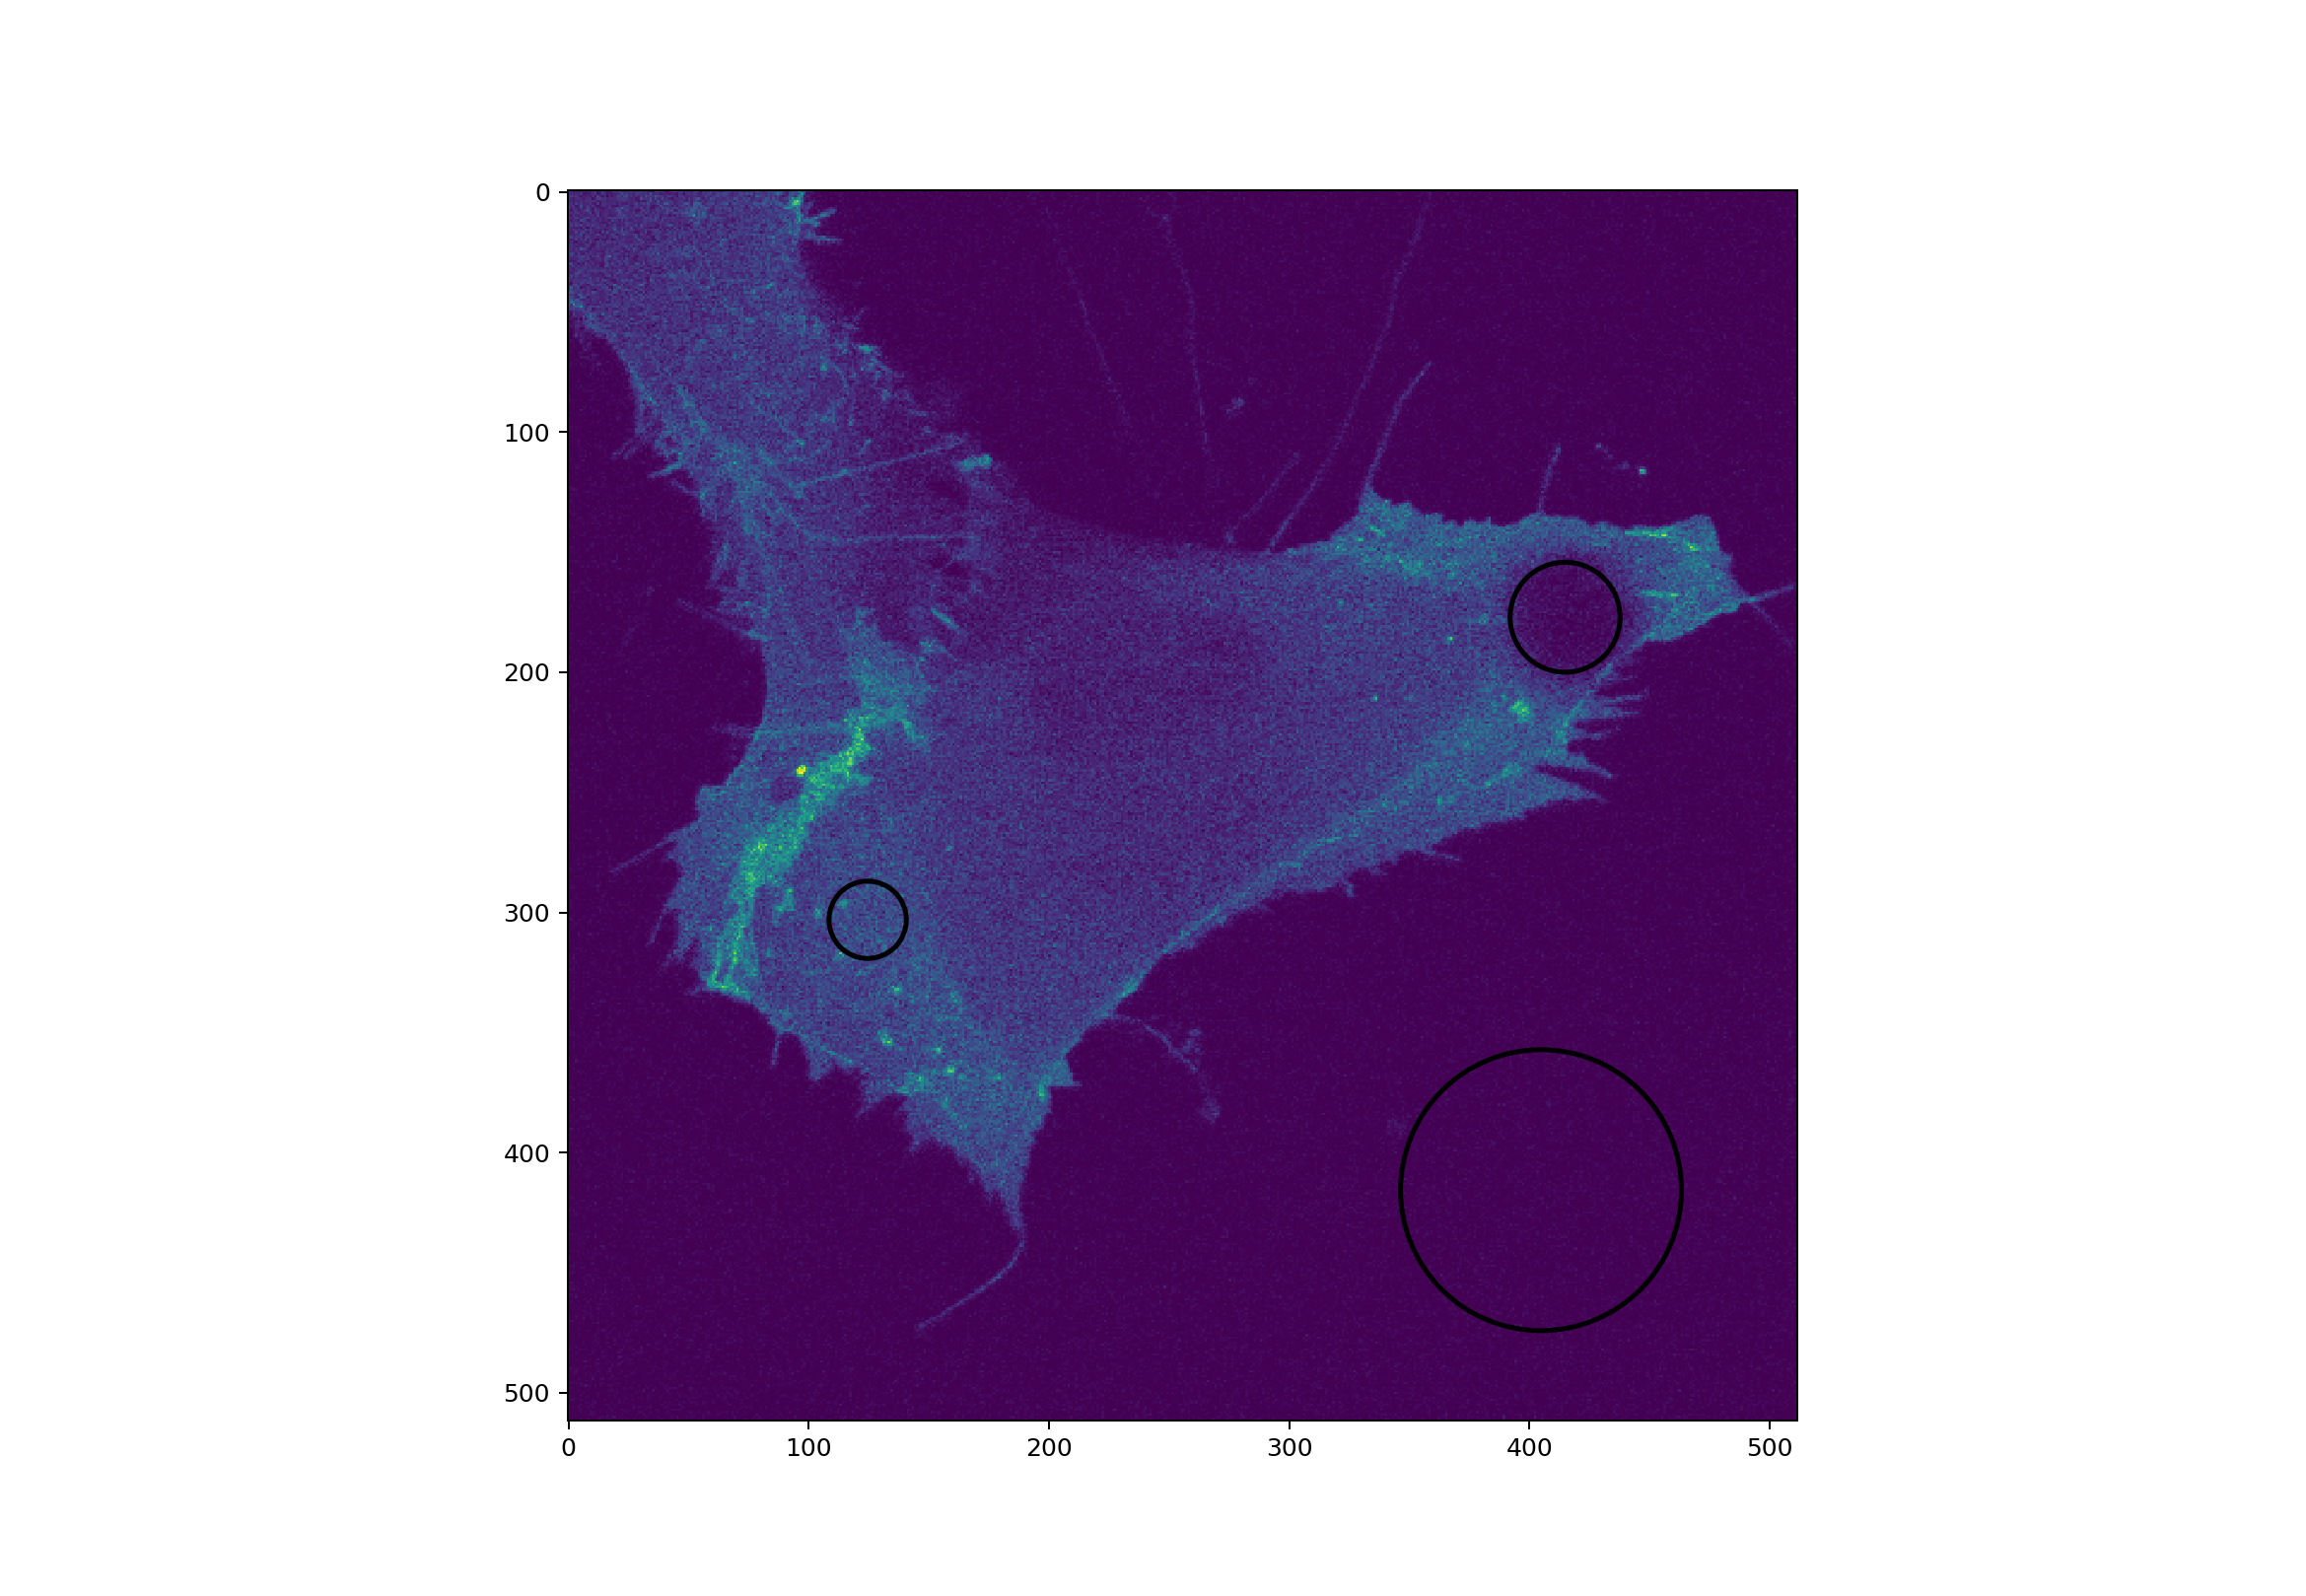

In [336]:
fig = plt.figure(figsize=(13,9))

image_ax = plt.imshow(img[:,:,3])

for roi in ['ROI:1', 'ROI:0', 'ROI:2']:
    RadiusX, RadiusY, X, Y = map(rois_struc[roi][0].get, ('RadiusX', 'RadiusY', 'X', 'Y'))
    ellipse = patches.Ellipse(xy=(X, Y), width=2*RadiusX, height=2*RadiusY, linewidth=2.0, fill=False)
    fig.gca().add_artist(ellipse)

# ax.set_aspect('equal')

In [ ]:
# cut segment after bleaching
# find countour
# apply sobol filter for S_x and S_y
# get atan(S_y/S_x)
# calculate mean for some number of frames show arrow with amplitude in points


In [41]:
stop_bioformats()

BioContainer closed
